**In previous notebooks we cleaned the data, performed EDA and evaluated different models. This notebook contains data training using BERT pretrained model in Keras.**

### Installing Dependencies

In [2]:
# Dependency for bert inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 8.4MB/s 


In [3]:
# For using adam optimizer from tensor flow models
!pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 8.7MB/s 
     |████████████████████████████████| 1.2MB 33.6MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 645kB 33.1MB/s 
     |████████████████████████████████| 358kB 33.1MB/s 
     |████████████████████████████████| 706kB 44.4MB/s 
     |████████████████████████████████| 174kB 44.2MB/s 
     |████████████████████████████████| 37.6MB 1.5MB/s 
     |████████████████████████████████| 102kB 8.4MB/s 


## Import Packages

In [4]:
import os
import numpy as np
import pandas as pd
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix , plot_roc_curve

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from official.nlp import optimization  

import matplotlib.pyplot as plt

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [38]:
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
%cd /content/drive/My Drive/Capstone/Data/

/content/drive/.shortcut-targets-by-id/1oPJof-sZbxMW4yf3cLG3l2yFEepNLfxR/Capstone/Data


## Import Cleaned Data

We will use the cleaned data exported during the cleaning process.

In [ ]:
train = pd.read_csv("train_clean_lemmatize.csv")

In [ ]:
train.shape

(1778628, 35)

In [ ]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,comment_cleaned,comment_lemmatized,target_label
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,this is so cool it like would you want your mo...,cool like would want mother read realli great ...,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,thank you this would make my life lot less anx...,thank would make life lot less anxieti induc k...,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,this is such an urgent design problem kudos to...,urgent design problem kudo take impress,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,is this something ll be able to install on my ...,someth abl instal site releas,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,haha you guys are bunch of losers,haha guy bunch loser,1


## Declare Features & Target

Declaring feature and target for the bert model. Bert model does not require to remove the stopwords and lemmatize the data. Hence we will use the comment_cleaned, where the comments text are lower cased and punctuations have been removed.

In [ ]:
X = train['comment_cleaned']
y = train['target_label']

## Train/Test Split

We will split our data into train and validation set and stratify by y so that our subsets have equal distributoion of labels.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1333971,) (1333971,) (444657,) (444657,)


## Modelling

We will use pretrained BERT model by loading through TensorFlow Hub and will use this model to fine tune. 

The text inputs for BERT needs to be transformed to numeric vectors/tensors. TensorFlow Hub provides a matching preprocessing model for BERT, which implements this transformation.

### Declare Pretrained Models

Declaring links to BERT pretrained model and preprocessing model.

In [ ]:
bert_model_handler = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_preprocessor = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
def build_classifier_model():
    
    # Declaring Input
    text_input = tf.keras.layers.Input(shape=(), 
                                       dtype=tf.string, name='text')
    
    # Loading the preprocessing model using Keras
    preprocessing_layer = hub.KerasLayer(bert_preprocessor, 
                                         name='preprocessing')

    # Passing the input to preprocessing layer to convert the text to vectors 
    encoder_inputs = preprocessing_layer(text_input)

    # Loading BERT model
    encoder = hub.KerasLayer(bert_model_handler, trainable=True, name='BERT_encoder')
    
    # passing the processed inputs to BERT model
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']

    # Additional layers
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, 
                                activation='sigmoid', 
                                name='classifier')(net)
    
    model = tf.keras.Model(text_input, net)
    
    # Declaring the loss, metrics and optimizer for compilation
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = [tf.metrics.BinaryAccuracy('accuracy'), tf.metrics.Recall()]
    
    epochs = 6
    steps_per_epoch = int(X_train.shape[0] / 32)
    num_train_steps = steps_per_epoch * epochs
    num_warm_steps = int(0.1 * num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=1e-5,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warm_steps)

    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metric)
    return model

In [ ]:
classifier_model = build_classifier_model()

### Model Summary

In [ ]:
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

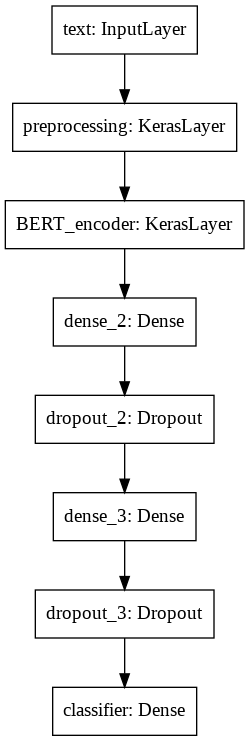

In [ ]:
tf.keras.utils.plot_model(classifier_model)

Above summary and plot describes the model architecture used for training. 2 Dense layers with dropout of 0.1 was added on top of the original BERT model.

### Training

The training of the data has been done in two parts. At first model is trained for 1 epoch and later it has been trained for 5 epochs. This has been done considering the huge dataset and time and resource constraints.

While training the model for 5 epochs, early stopping has been used for monitoring the over fitting on validation loss.

In [ ]:
checkpoint_path = '/content/drive/My Drive/Capstone/Code/BaseModels/BertFull'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1)

history = classifier_model.fit(x=X_train.values,
                               y=y_train.values,
                               validation_data=(X_val.values, y_val.values),
                               epochs=1,
                               batch_size=32,
                               callbacks=[checkpoint])

41687/41687 [==============================] - 6125s 147ms/step - loss: 0.2216 - accuracy: 0.9260 - recall_2: 0.3024 - val_loss: 0.1325 - val_accuracy: 0.9496 - val_recall_2: 0.6359

Epoch 00001: saving model to /content/drive/My Drive/Capstone/Code/BaseModels/BertFull


In [ ]:
checkpoint_path = '/content/drive/My Drive/Capstone/Code/BaseModels/BertFull'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = classifier_model.fit(x=X_train.values,
                               y=y_train.values,
                               validation_data=(X_val.values, y_val.values),
                               epochs=5,
                               batch_size=32,
                               callbacks=[earlystopping])

Epoch 1/5
41687/41687 [==============================] - 6173s 148ms/step - loss: 0.1267 - accuracy: 0.9525 - recall_2: 0.5762 - val_loss: 0.1270 - val_accuracy: 0.9513 - val_recall_2: 0.6504
Epoch 2/5
41687/41687 [==============================] - 6187s 148ms/step - loss: 0.1178 - accuracy: 0.9559 - recall_2: 0.6114 - val_loss: 0.1336 - val_accuracy: 0.9524 - val_recall_2: 0.6330
Epoch 3/5
41687/41687 [==============================] - 6197s 149ms/step - loss: 0.1108 - accuracy: 0.9587 - recall_2: 0.6442 - val_loss: 0.1362 - val_accuracy: 0.9507 - val_recall_2: 0.6708
Epoch 4/5
41687/41687 [==============================] - 6222s 149ms/step - loss: 0.1048 - accuracy: 0.9613 - recall_2: 0.6678 - val_loss: 0.1397 - val_accuracy: 0.9506 - val_recall_2: 0.6535


In [ ]:
classifier_model.save('/content/drive/My Drive/Capstone/Code/BaseModels/BertFull', include_optimizer=False)

Above we can see that though the model was supposed to train for 5 epochs, it stopped at 4 as it later turned out to be overfitting.

Let us understand the loss and accurcay plots for the model

### Loss & Accuracy plot

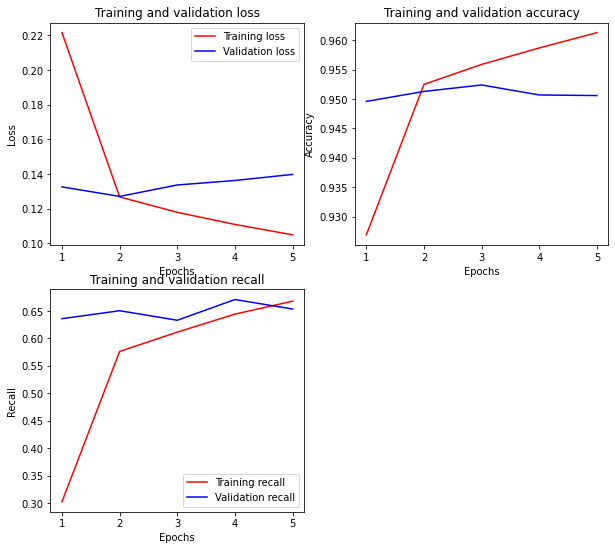

In [36]:
#history_dict = history.history
#print(history_dict.keys())

acc = [0.9269, 0.9525, 0.9559, 0.9587, 0.9613] 
val_acc = [0.9496, 0.9513, 0.9524, 0.9507, 0.9506] 
loss = [0.2216, 0.1267, 0.1178, 0.1108, 0.1048]
val_loss = [0.1325, 0.1270, 0.1336, 0.1362, 0.1397]
recall = [0.3024, 0.5762, 0.6114, 0.6442, 0.6678] 
val_recall = [0.6359, 0.6504, 0.6330, 0.6708, 0.6535]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 9))
fig.tight_layout(pad=0.5)

plt.subplot(2, 2, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')

plt.legend(loc='lower right')

From the loss plot above we can see that the train and validation loss converged at second epoch. But it started to overfit from the third epoch.

Similarly for accurcay plot, the train and validation accuracy converged at second epoch but it again started t0 diverge causing overfitting.

Now for recall plot, the model did converge for train and validation after epoch 3. 

As we have used early stopping with restore_best_weights as True, we will get the best model adn we will use this for our final evaluation.

## Overall Model Comparision

Below is the comparision for accuracy and recall among the models we tried. Looking at the scores we can clearly see that BERT model has the highest accuracy and recall as compared to Logistic Regression and Random Forest.

Hence our final model is BERT and we will use it for test data evaluation and prediction.

In [6]:
scores = [['Logistic Regression', 0.43, 0.94],
          ['Random Forest', 0.61, 0.83],
          ['Bert', 0.63, 0.95]]
print (tabulate(scores, headers=["", "Recall", "Accuracy"]))

                       Recall    Accuracy
-------------------  --------  ----------
Logistic Regression      0.43        0.94
Random Forest            0.61        0.83
Bert                     0.63        0.95


## Predicting Test

### Import Cleaned Test Data

In [40]:
test = pd.read_csv('test_clean.csv')

In [41]:
test.head()

,id,comment_text,toxicity,target_label
0,7097320,[ Integrity means that you pay your debts.]\n\...,0.0,0
1,7097321,This is malfeasance by the Administrator and t...,0.1,0
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,0.3,0
3,7097323,"Paul: Thank you for your kind words. I do, in...",0.0,0
4,7097324,Sorry you missed high school. Eisenhower sent ...,0.0,0


In [42]:
test.shape

(96862, 4)

### Evaluate

In [ ]:
classifier_model.evaluate(x = test['comment_text'], y = test['target_label']) 

3027/3027 [==============================] - 233s 77ms/step - loss: 0.1251 - accuracy: 0.9524 - recall_2: 0.6459


[0.12509018182754517, 0.9523858428001404, 0.6459490656852722]

Model is able to classify the toxic comments for test data with **95% accuracy** and **64% recall**.

### Predict

We will predict the toxic comments using the bert model, save the probabilities and classes to test and export the updated test file for later evaluation.

In [ ]:
predict_prob = classifier_model.predict(test['comment_text'])

In [ ]:
predict_class = [1 if x >= 0.5 else 0 for x in predict_prob]

In [ ]:
test['predict_prob'] = predict_prob
test['predict_class'] = predict_class

In [ ]:
test.to_csv('/content/drive/My Drive/Capstone/Data/test_predictions.csv')

### Prediction Evaluation

Let us evaluate the predictions for test data.
The main objective of this project is to reduce the unintended bias towards any identity attribute. Hence, we will check whether the model was able to detect this or not by highlighting few of the predictions. 

In [43]:
test_predictions = pd.read_csv('test_predictions.csv')

In [63]:
test_predictions.iloc[[94502, 546, 96371, 10239, 6355, 15055, 30008], [2, 4, 6]]

,comment_text,target_label,predict_class
94502,Let us pray that these African Christians do not say anything to upset NCR's staff and readership regarding Western indoctrination on the subject of gay marriage.,0,0
546,Are you trying to say that black people are more likely to be mentally ill murderers?,1,1
96371,I feel your pain. I barely survived a shotgun gas station holdup by two black men back in 1968.,0,0
10239,Canada is not diverse.. Its mostly white with some asians..,0,0
6355,"You're ""sad"" or ""disagree"" with my comment? Then kindly explain what Chrystia Freeland and the Liberal government are doing for the persecuted homosexuals in Saudi Arabia.",1,1
15055,"No, the real problem is perpetuated ignorance of human sexuality and the notion homosexuality is still considered a sin within a loving, committed relationship.",0,0
30008,"Aw, even gay guys dump you?",1,1


From few of the examples above, we can see that our model was able to detect the identity bias. Though identities like gay, black, homosexual, etc were mentioned in the comment, it did not blindly categorize it as toxic.

However there is still scope of improvement as we can see from below sample comments that the model did detect the identity attribute as toxic for some comments.

In [73]:
test_predictions.iloc[[95490, 43951, 12400], [2, 4, 6]]

,comment_text,target_label,predict_class
95490,What about police officers who are gay?,0,1
43951,Swift's acceptance speech about defying the odds and oppression that all white blonde female MOR artists face in the music industry was truly inspiring. Entitled Hip-Hop artists take note!,0,1
12400,Doggone it.What a does black president have to do with anything? Why does color always have to come up?,0,1


## Conclusion & Recommendation

**Conclusion:**

We were able to build a model using **BERT** that can detect identity biased toxicity in the comments over the internet with test <br> **Accuracy : 95% **and **Recall : 64%**.

**Recommendation:**

Most online communities have some rules and regulations for commenting. For some platforms, moderators delete offensive comments or even close the article/post because of the destructive conversations. 

This model would help the online platforms to regulate the insults, threats and toxic comments by identifying and deleting them or not allowing to post such comment. This will help the future conversations to be more productive and positive.